In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set the path to your dataset
#BASE_PATH_TRAIN = "C:\\kaggle\\input\\ArTaxOr"
#BASE_PATH_TEST = "C:\\DL Testing Set"

BASE_PATH_TRAIN = "C:\\DL Testing Set"
BASE_PATH_TEST = "C:\\kaggle\\input\\ArTaxOr"


# Step 1: Image Preprocessing
image_train = []
labels_train = []

for root, dirs, files in os.walk(BASE_PATH_TRAIN):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_train.append(os.path.join(root, file))
                labels_train.append(label)

data_train = {'Images': image_train, 'labels': labels_train}
data_train = pd.DataFrame(data_train)

lb = LabelEncoder()
data_train['encoded_labels'] = lb.fit_transform(data_train['labels'])

image_test = []
labels_test = []

for root, dirs, files in os.walk(BASE_PATH_TEST):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_test.append(os.path.join(root, file))
                labels_test.append(label)

data_test = {'Images': image_test, 'labels': labels_test}
data_test = pd.DataFrame(data_test)

data_test['encoded_labels'] = lb.transform(data_test['labels'])



In [3]:
# Number of classes (insects)
num_classes = len(lb.classes_)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create data generator
batch_size = 64



In [4]:
# Define a data generator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Define a data generator for testing
test_gen = ImageDataGenerator(rescale=1./255.)

# Training Data Generator

train_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)



Found 11496 validated image filenames belonging to 7 classes.
Found 2874 validated image filenames belonging to 7 classes.


In [5]:
# Step 2: Model Modification for Insect Classification using DenseNet121
def get_densenet_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [9]:
# Compile the model
densenet_model = get_densenet_model(num_classes)

densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()]
)


# Train the model
history_densenet = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStopping(patience=3)]
)

# Save the model
densenet_model.save("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_densenet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/mobdensenet_history.csv", index=False)

29084464/29084464 [==============================] - 1s 0us/step


C:\Users\Nicole\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
180/180 [==============================] - 3871s 21s/step - loss: 1.0649 - accuracy: 0.6536 - recall: 0.5379 - precision: 0.8003 - auc: 0.8997 - val_loss: 1.1963 - val_accuracy: 0.6030 - val_recall: 0.4544 - val_precision: 0.7109 - val_auc: 0.8765
Epoch 2/10
180/180 [==============================] - 3817s 21s/step - loss: 0.7097 - accuracy: 0.7629 - recall: 0.6676 - precision: 0.8713 - auc: 0.9571 - val_loss: 1.1184 - val_accuracy: 0.6249 - val_recall: 0.5108 - val_precision: 0.7289 - val_auc: 0.8938
Epoch 3/10
180/180 [==============================] - 3763s 21s/step - loss: 0.6214 - accuracy: 0.7937 - recall: 0.7092 - precision: 0.8824 - auc: 0.9673 - val_loss: 1.0566 - val_accuracy: 0.6493 - val_recall: 0.5421 - val_precision: 0.7472 - val_auc: 0.9056
Epoch 4/10
180/180 [==============================] - 3830s 21s/step - loss: 0.5668 - accuracy: 0.8097 - recall: 0.7345 - precision: 0.8907 - auc: 0.9730 - val_loss: 0.9555 - val_accuracy: 0.6788 - val_recall: 0.5835 - val_

# Plot Loss and Accuracy

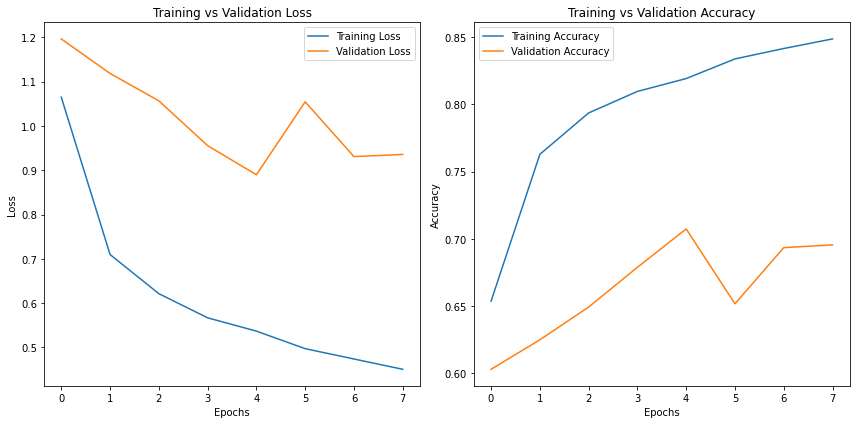

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/mobdensenet_history.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Remove Early Stopping

In [6]:
# Compile the model
densenet_model = get_densenet_model(num_classes)

densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.001, momentum=0.9),
    metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()]
)


# Train the model
history_densenet = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
    #,callbacks=[EarlyStopping(patience=3)]
)

# Save the model
densenet_model.save("C:/Deep Learning/Project/Classification Models/mobdensenet_modelv2.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_densenet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/mobdensenet_historyv2.csv", index=False)

C:\Users\Nicole\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
180/180 [==============================] - 3889s 21s/step - loss: 1.0554 - accuracy: 0.6514 - recall: 0.5320 - precision: 0.8028 - auc: 0.9020 - val_loss: 1.0216 - val_accuracy: 0.6712 - val_recall: 0.5254 - val_precision: 0.7947 - val_auc: 0.9097
Epoch 2/10
180/180 [==============================] - 3697s 21s/step - loss: 0.7029 - accuracy: 0.7641 - recall: 0.6680 - precision: 0.8693 - auc: 0.9581 - val_loss: 0.8734 - val_accuracy: 0.7157 - val_recall: 0.6047 - val_precision: 0.8087 - val_auc: 0.9343
Epoch 3/10
180/180 [==============================] - 3701s 21s/step - loss: 0.6125 - accuracy: 0.7950 - recall: 0.7117 - precision: 0.8853 - auc: 0.9682 - val_loss: 0.9198 - val_accuracy: 0.6987 - val_recall: 0.5974 - val_precision: 0.7912 - val_auc: 0.9272
Epoch 4/10
180/180 [==============================] - 3703s 21s/step - loss: 0.5670 - accuracy: 0.8085 - recall: 0.7359 - precision: 0.8919 - auc: 0.9727 - val_loss: 1.0638 - val_accuracy: 0.6517 - val_recall: 0.5564 - val_

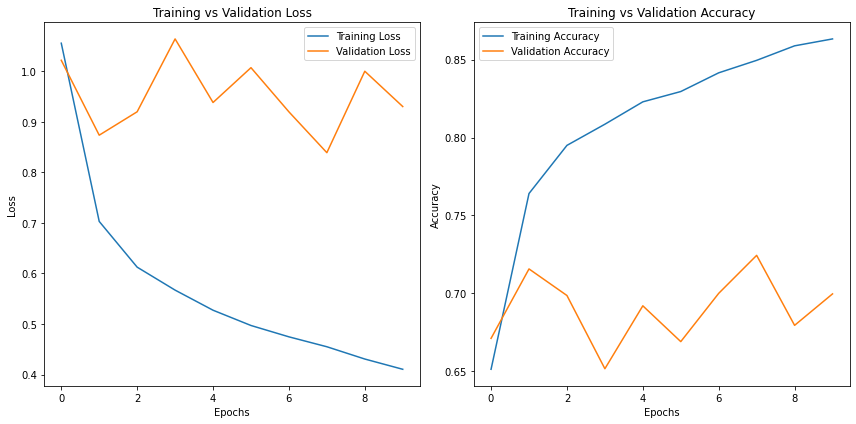

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/mobdensenet_historyv2.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Removing Early Stopping Did not improve accuracy by much, hence using original model

In [7]:
from keras.models import load_model
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Test accuracy with ArTaxOr

In [8]:
# Test accuracy
test_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col="Images",
    y_col="labels",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

# Evaluate the model on the test set
test_results = densenet_model.evaluate(test_generator)

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


Found 15376 validated image filenames belonging to 7 classes.
241/241 [==============================] - 1854s 8s/step - loss: 1.3224 - accuracy: 0.5505 - recall: 0.4598 - precision: 0.6580 - auc: 0.8643
DenseNet Test Loss: 1.3223575353622437
DenseNet Test Accuracy: 0.5505332946777344


# Test Accuracy with ArTaxOr

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 3239s 13s/step - loss: 1.3069 - accuracy: 0.5526 - recall: 0.4504 - precision: 0.6654 - auc: 0.8644
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 3069s 13s/step
DenseNet Test Loss: 1.3069095611572266
DenseNet Test Accuracy: 0.5526144504547119
1/1 [==============================] - 0s 133ms/step


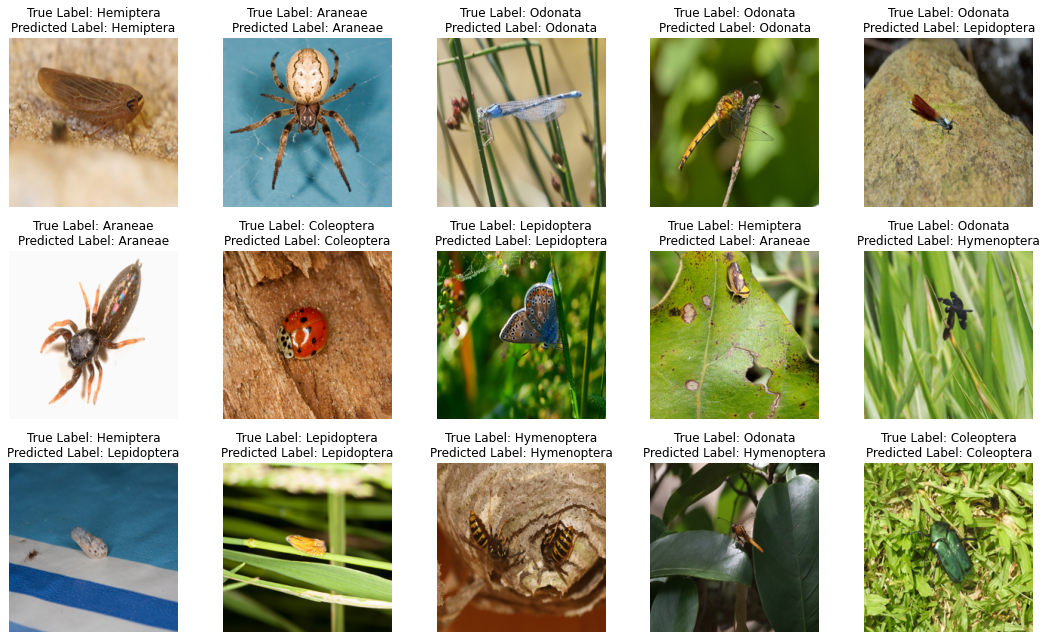

Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1801s 7s/step - loss: 1.3069 - accuracy: 0.5526 - recall: 0.4504 - precision: 0.6654 - auc: 0.8644
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1829s 8s/step


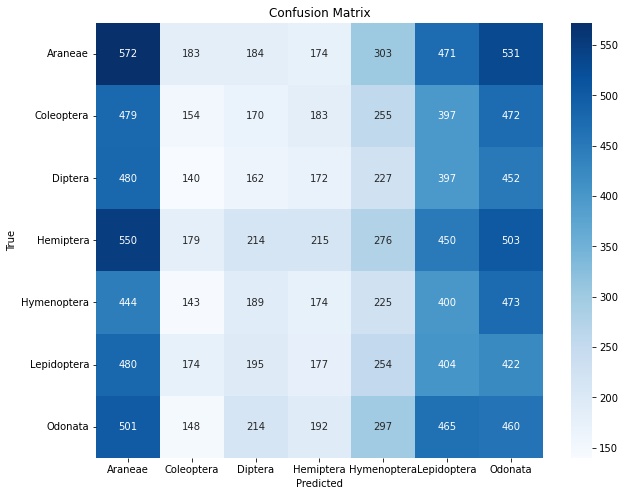

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.16      0.24      0.19      2418
  Coleoptera       0.14      0.07      0.10      2110
     Diptera       0.12      0.08      0.10      2030
   Hemiptera       0.17      0.09      0.12      2387
 Hymenoptera       0.12      0.11      0.12      2048
 Lepidoptera       0.14      0.19      0.16      2106
     Odonata       0.14      0.20      0.16      2277

    accuracy                           0.14     15376
   macro avg       0.14      0.14      0.13     15376
weighted avg       0.14      0.14      0.14     15376



In [9]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Test Accuracy with Mobile ArTaxOr Corpus

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 67s 15s/step - loss: 0.8502 - accuracy: 0.7031 - recall: 0.6026 - precision: 0.7841 - auc: 0.9387
Found 229 images belonging to 7 classes.
4/4 [==============================] - 67s 15s/step
DenseNet Test Loss: 0.8502436280250549
DenseNet Test Accuracy: 0.7030567526817322
1/1 [==============================] - 0s 159ms/step


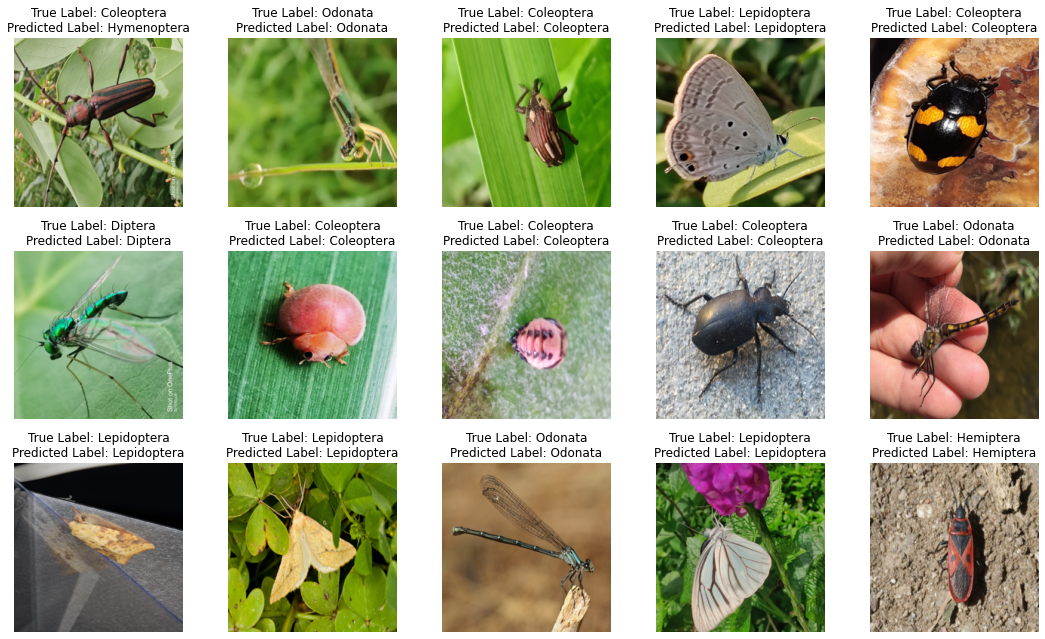

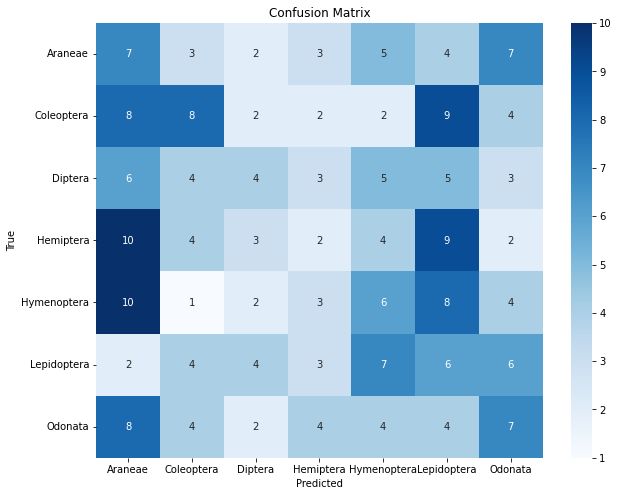

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.14      0.23      0.17        31
  Coleoptera       0.29      0.23      0.25        35
     Diptera       0.21      0.13      0.16        30
   Hemiptera       0.10      0.06      0.07        34
 Hymenoptera       0.18      0.18      0.18        34
 Lepidoptera       0.13      0.19      0.16        32
     Odonata       0.21      0.21      0.21        33

    accuracy                           0.17       229
   macro avg       0.18      0.17      0.17       229
weighted avg       0.18      0.17      0.17       229



In [10]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# Testing with Small DL Set

          labels  encoded_labels
0        Araneae               0
15    Coleoptera               1
35       Diptera               2
50     Hemiptera               3
69   Hymenoptera               4
88   Lepidoptera               5
103      Odonata               6
Found 118 images belonging to 7 classes.
2/2 [==============================] - 46s 17s/step - loss: 0.6480 - accuracy: 0.7797 - recall: 0.6949 - precision: 0.8283 - auc: 0.9640
Found 118 images belonging to 7 classes.
2/2 [==============================] - 51s 20s/step
DenseNet Test Loss: 0.6479625105857849
DenseNet Test Accuracy: 0.7796609997749329
1/1 [==============================] - 0s 181ms/step


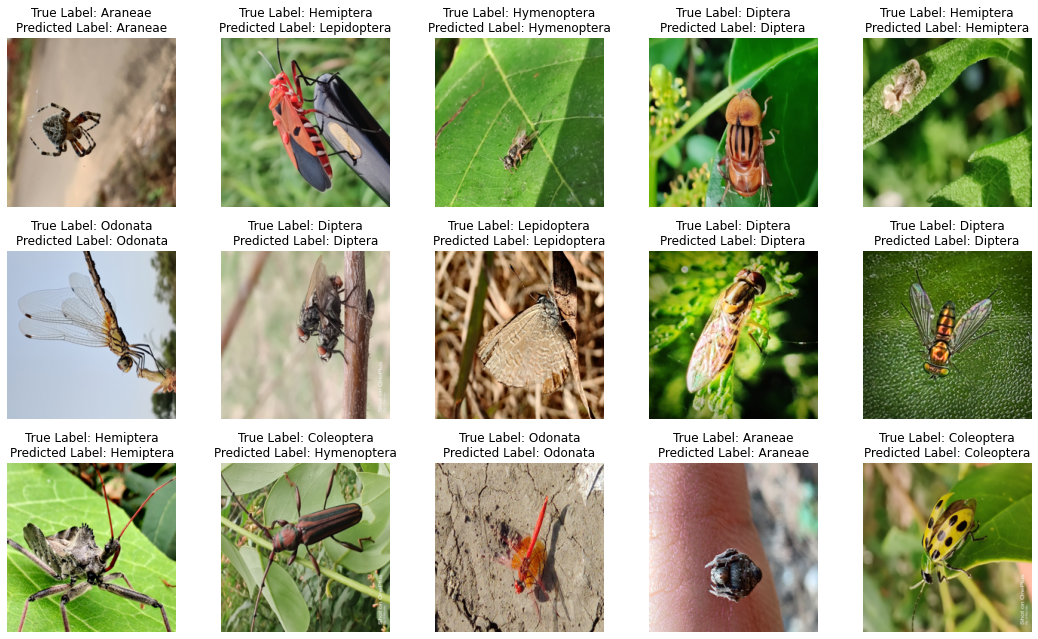

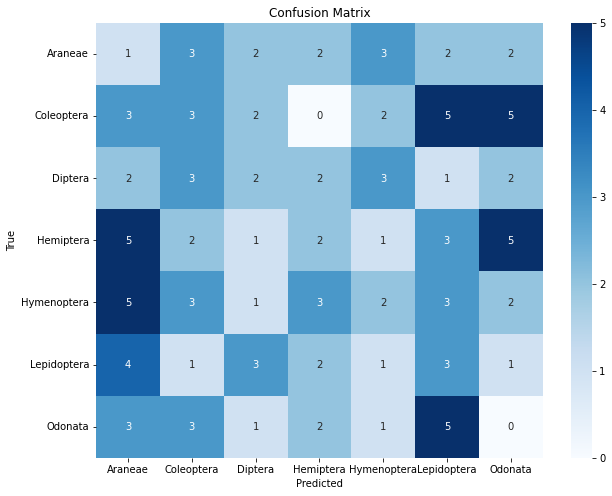

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.04      0.07      0.05        15
  Coleoptera       0.17      0.15      0.16        20
     Diptera       0.17      0.13      0.15        15
   Hemiptera       0.15      0.11      0.12        19
 Hymenoptera       0.15      0.11      0.12        19
 Lepidoptera       0.14      0.20      0.16        15
     Odonata       0.00      0.00      0.00        15

    accuracy                           0.11       118
   macro avg       0.12      0.11      0.11       118
weighted avg       0.12      0.11      0.11       118



In [11]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Testing with Mobile Corpus

            labels  encoded_labels
0          Araneae               0
4776    Coleoptera               1
5315       Diptera               2
5892     Hemiptera               3
6580   Hymenoptera               4
7251   Lepidoptera               5
10649      Odonata               6
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 4643s 20s/step - loss: 0.4836 - accuracy: 0.8456 - recall: 0.7841 - precision: 0.9053 - auc: 0.9794
Found 14530 images belonging to 7 classes.
228/228 [==============================] - 2451s 11s/step
DenseNet Test Loss: 0.4836386442184448
DenseNet Test Accuracy: 0.8456297516822815
1/1 [==============================] - 0s 97ms/step


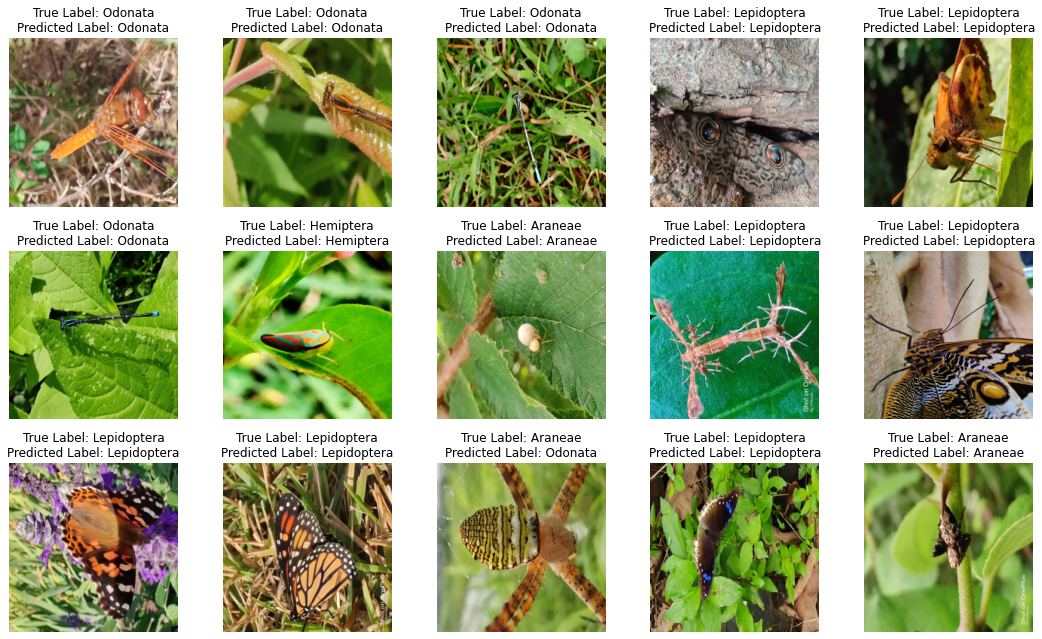

In [5]:

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Confusion Matrices

## Mobile-ArTaxOR Mix set

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 105ms/step


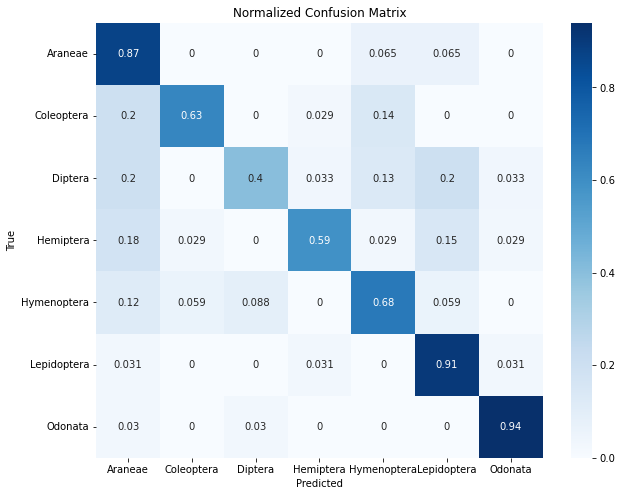

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.52      0.87      0.65        31
  Coleoptera       0.88      0.63      0.73        35
     Diptera       0.75      0.40      0.52        30
   Hemiptera       0.87      0.59      0.70        34
 Hymenoptera       0.66      0.68      0.67        34
 Lepidoptera       0.66      0.91      0.76        32
     Odonata       0.91      0.94      0.93        33

    accuracy                           0.72       229
   macro avg       0.75      0.72      0.71       229
weighted avg       0.75      0.72      0.71       229



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

## ArTaxOr

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

## Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/mobdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

In [2]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from tensorflow.keras.models import Model

num_classes = 7

# Create DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers

num_classes = 7

# Create DenseNet121 base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the Sequential model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 7)                 7175      
                                                                 
Total params: 8,094,279
Trainable params: 1,056,775
Non-trainable params: 7,037,504
______________________________________